# [COM3240] Lab 8: Reinforcement Learning on the Mountain Car Problem - Solution

## Overview of the task

 The car depicted in the figure needs to reach the goal location. However, it does not have enough power to reach it directly and it needs to oscillate to build up momentum. The agent can make three possible actions: to go right, left, or to wait. A reward of 1 is delivered if the car reaches the goal, otherwise the reward is -1. 

<img src="Env.png" width="500" height="500">

The difficulty of task is caused by the fact that the agent can start improving its policy only after it has reached the goal location. However, the optimal strategy includes actions where the agent goes further from the goal location. 


## Overview of the environment

MountainCar.py contains the class MountainCar, which has three methods.

**1. .reset** -> resets the environment to the starting location and velocity of the car. The staring location is random in the interval $[-0.6-0.4[$, the starting velocity is $0$.

**2. .step** -> takes as input the action made, updates the environment (computes the new position and velocity), and gives the reward. The output of the method consists of: the new position, the new velocity, the reward, a boolean variable that is True in the case the final location has been reached and False otherwise.

**3. .Create_Animation** -> takes as input a succession of locations and uses those to generate an animation.

An example of two agents, one at the beginning of training that is unable to solve the task, and one after training, are shown in the animations below. 

## Exercises

**1. Use SARSA to solve the problem**
- See 'TODO1' in the comments
- The pseudocode is provided below and at the start of section 'Implement the SARSA Algorithm'
- Make sure to use the arrays needed to run the plots, see 'CHECK1', 'CHECK2', & 'CHECK3' in the comments

**2. Implement the eligibility traces**
- When implementing eligibility traces, consider changing the learning rate. 
- See also the solution
   
   <img src="SARSA_eligibilityTraces_scheme.png" width="500" height="300">
    
**3. Study and understand the notebook on value function approximation** 
- Try to implement the training loop of that notebook without copying it.


**4. Understand the practical differences between SARSA and Q-learning**
- See the pseudocodes below. 
- Could you implement Q-learning? 
- Why in SARSA $s\leftarrow s'$ and $a\leftarrow a'$ at the end of a step, while in Q-learning $s\leftarrow s'$?

   <img src="SARSA_scheme.png" width="900" height="600">
   <img src="Qlearning_scheme.png" width="900" height="600">



## Loading and plotting the Environment

In [1]:
import numpy as np
import numpy.matlib 
import math
import matplotlib.pyplot as plt
import csv
from MountainCar import * ## We import the script from the MountainCar.py

In [2]:
## Definde the environment
Env=MountainCar()

<IPython.core.display.Javascript object>


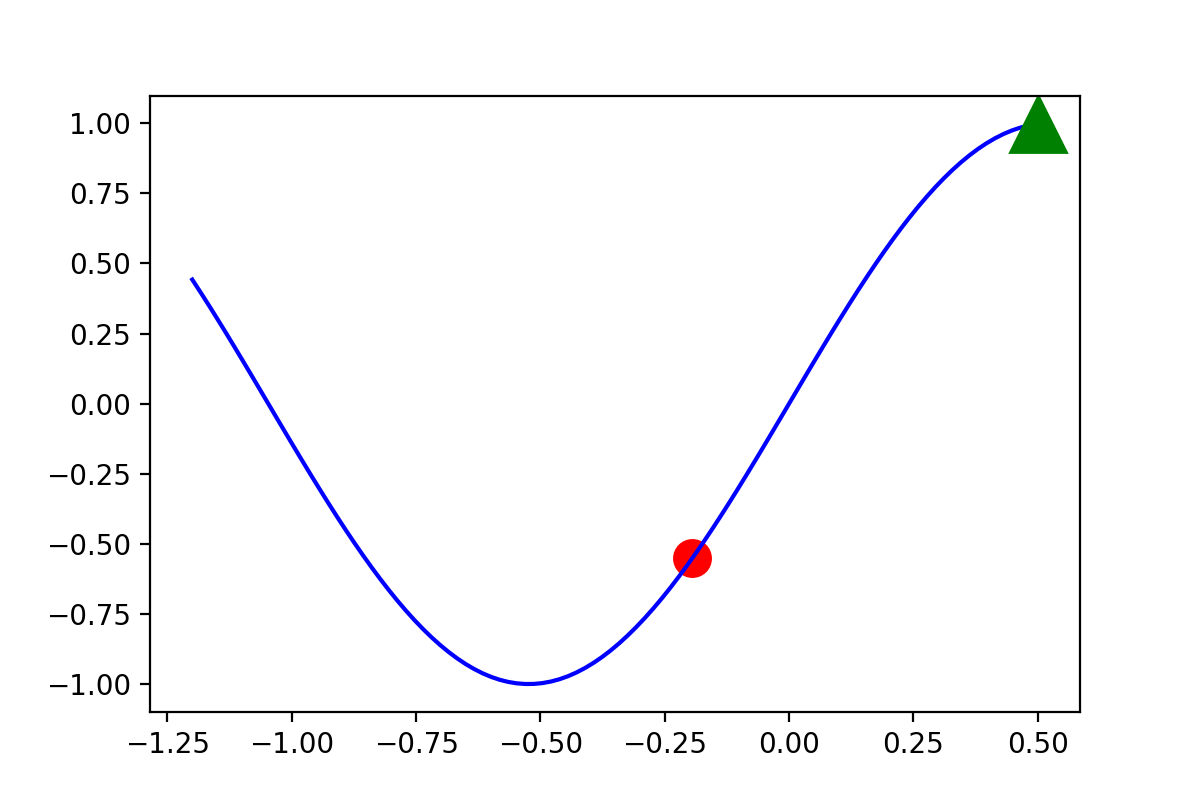

In [3]:
from matplotlib.animation import FuncAnimation
%matplotlib notebook

## Loading the positions of an episode run by the agent after training (saved in GoodAgent.npy) 
Position_GoodAgent=np.load('GoodAgent.npy')

## Loading the positions of an episode run by an agent before training (saved in GoodAgent.npy) 
Position_BadAgent=np.load('BadAgent.npy')

# Select Good=1 to create an animation for the data of the optimised agent.
# Select Good=0 to create an animation for the data of the agent before training.

Good=1
if Good==1:
    
    anim=Env.Create_Animation(Position_GoodAgent)
    plt.show()

else:
    
    anim=Env.Create_Animation(Position_BadAgent)
    plt.show()


## Helpful variables and function

In [4]:
## In the first approach, we will create a table of Qvalues
## Given that we have speed and velocities, we will discretize both variables and create a 2-d table for the states

## CREATE THE COORDINATES OF THE TABLE AND INTIALISE Q-VALUES

X_m=-1.2 ## MINIMUM POSITION
X_M=0.5  ## MAXIMUM POSITION

N_x=50   ## SIZE OF THE GRID ACROSS THE POSITION 
X=np.linspace(X_m,X_M,N_x) ## LIMITS OF THE GRID

V_m=-0.07 ## MINIMUM SPEED
V_M=0.07  ## MAXIMUM SPEED

N_v=50   ## SIZE OF THE GRID ACROSS THE VELOCITY
V=np.linspace(V_m,V_M,N_v) ## LIMITS OF THE GRID

N_a=3 ## NUMBER OF ACTIONS   

## The Q-values will be initialised with small random numbers centered around zero. 
## Thus, considering that all the rewards are -1 except the one at the goal location, 
### this initialisation performs an optimistic policy and encourages exploration despite
### the choice of a small value of epsilon. 
## The Q-values will need to decay from 0 to -1 at the beginning of training. 
### Thus, after the Q-value of a specific state-action pair has been updated and has decayed, 
### the agent will try the other available actions. 

## INITIALISE QVALUES, the second and the third dimension corresponds to the states
Qtable=np.random.randn(N_a,N_x,N_v)/1000 
gamma=0.99 ## gamma value
epsilon=0.01 ## epsilon value for the exploration
eta=0.5 ## learning rate


In [5]:
## DEFINE THE EPSILON-GREEDY POLICY

def EpsilonGreedy_Policy(Qvalues, epsilon):
    
    N_a=np.shape(Qvalues)[0]

    rand_value=np.random.uniform(0,1)

    rand_a=rand_value<epsilon

    if rand_a==True:

        a=np.random.randint(0,N_a)

    else:

        a=np.argmax(Qvalues)
            
    return a

## Implement the SARSA algorithm

<img src="SARSA_scheme.png" width="1000" height="700">


In [6]:
## TRAINING LOOP
## For each episode, the episode ends when the car reaches the goal. However, if the car has not reached the goal after 1000
## steps, please terminate the episode and reset the environemnt.


N_episodes=10000 ## Number of episodes
T=1000         ## Maximum number of actions per episode

## To perform the analysis below, please save the Positions, Speeds, Dones (the done value that the method Env.step() returns), and rewards 
## for each step and episode in the following arrays

Positions=np.zeros([N_episodes,T])
Speeds=np.zeros([N_episodes,T])
Dones=np.zeros([N_episodes,T])
Rs=np.zeros([N_episodes,T])

eligibility_trace=True
if eligibility_trace:    
    lamb=0.3
    eta=0.08

for n in range(N_episodes):
    
    # Initialise the position and velocity
    [pos,speed]=Env.reset()
    
    
    # Find the index in the table corresponding to the position and the velocity
    ind_x=np.sum(X<=pos)-1
    ind_v=np.sum(V<=speed)-1
    
    # Find the Qvalues corresponding to that state
    Qvalues=np.copy(Qtable[:,ind_x,ind_v])

    # Make an action
    a=EpsilonGreedy_Policy(Qvalues,epsilon)
    
    # Initialise eligibility traces 
    if eligibility_trace==True:
        
        e=np.zeros([N_a,N_x,N_v])
    
    
    for t in range(T):
        
        # Update the eligibility trace for the action made
        if eligibility_trace:
            
            e[a,ind_x,ind_v]=e[a,ind_x,ind_v]+1
        
        # Update the position and the velocity
        [pos1,speed1],R,Done=Env.step(a)
        
        # Save the position and velocities
        Speeds[n,t]=np.copy(speed1)
        Positions[n,t]=np.copy(pos1)
        Dones[n,t]=np.copy(Done)
        Rs[n,t]=np.copy(R)
        
        # If the episode has ended and the car has reached the goal, we reset the environment to a starting location
        if Done==True:
            
            # Compute the delta
            delta=R-Qtable[a,ind_x,ind_v]
            
            # Update the Qvalues
            Qtable[a,ind_x,ind_v]=Qtable[a,ind_x,ind_v]+eta*delta
            
            if eligibility_trace:
                
                Qtable=Qtable+eta*delta*e  
                
            
            break;
            
            
        # Find the index in the table corresponding to the new state
        ind_x1=np.sum(X<=pos1)-1
        ind_v1=np.sum(V<=speed1)-1
        
        # Compute the Qvalues for the new state
        Qvalues1=np.copy(Qtable[:,ind_x1,ind_v1])
        
        # Make an action with epsilon-greedy policy
        a1=EpsilonGreedy_Policy(Qvalues1,epsilon)
        
        # Compute the delta
        delta=R+gamma*Qtable[a1,ind_x1,ind_v1]-Qtable[a,ind_x,ind_v]
        
        # Update the Qvalues
        Qtable[a,ind_x,ind_v]=Qtable[a,ind_x,ind_v]+eta*delta
        
        # Update the Qvalues for the case with eligibility traces
        if eligibility_trace:
            
            # Note how, thanks to the concept of eligibility traces, we update all the Qvalues.
            # Practically, eligibility traces can be seen as a mask that is non zero for the state-action pairs visited
            Qtable=Qtable+eta*delta*e            
            
            # Update all the eligibility traces. We are moving to the next state, eligibility traces need to decay
            e=gamma*lamb*e    
        
        # The new state and action become the current state and action
        a=np.copy(a1)
        pos=np.copy(pos1)
        speed=np.copy(speed1)
        
        # The new indexes become the current indexes
        ind_x=np.copy(ind_x1)
        ind_v=np.copy(ind_v1)
            
        

The Best Episode is the number:  7570 Number of steps:  85


<IPython.core.display.Javascript object>


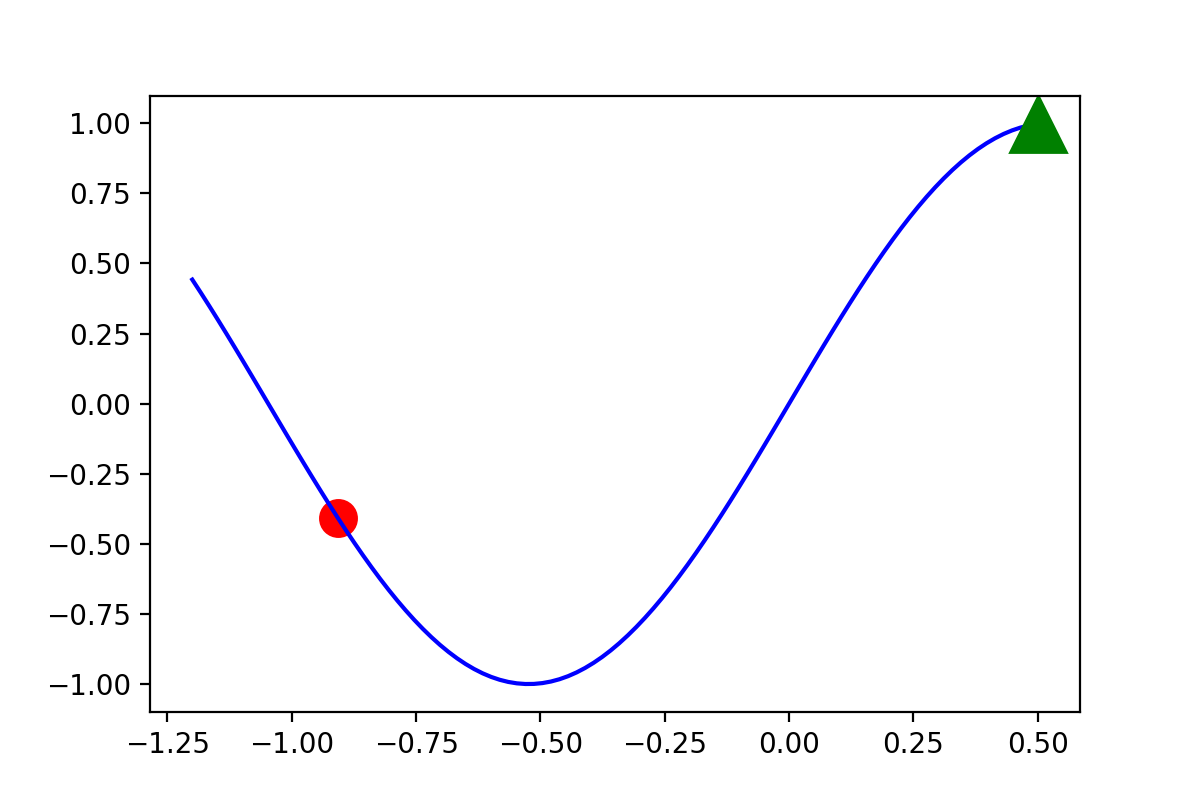

In [7]:
## PLOT THE BEST EPISODE
## The code in this cell will select the best episode (with highest reward) and animate it
## You will need to have saved the arrays Rs and Positions


from matplotlib.animation import FuncAnimation
%matplotlib notebook

Best_episode=np.argmax(np.sum(Rs,1))
Steps=int(np.abs(np.sum(Rs[Best_episode,:]))+1)

print('The Best Episode is the number: ', Best_episode, 'Number of steps: ', Steps)

Position=np.copy(Positions[Best_episode,0:Steps])    
anim=Env.Create_Animation(Position)
plt.show()



<IPython.core.display.Javascript object>


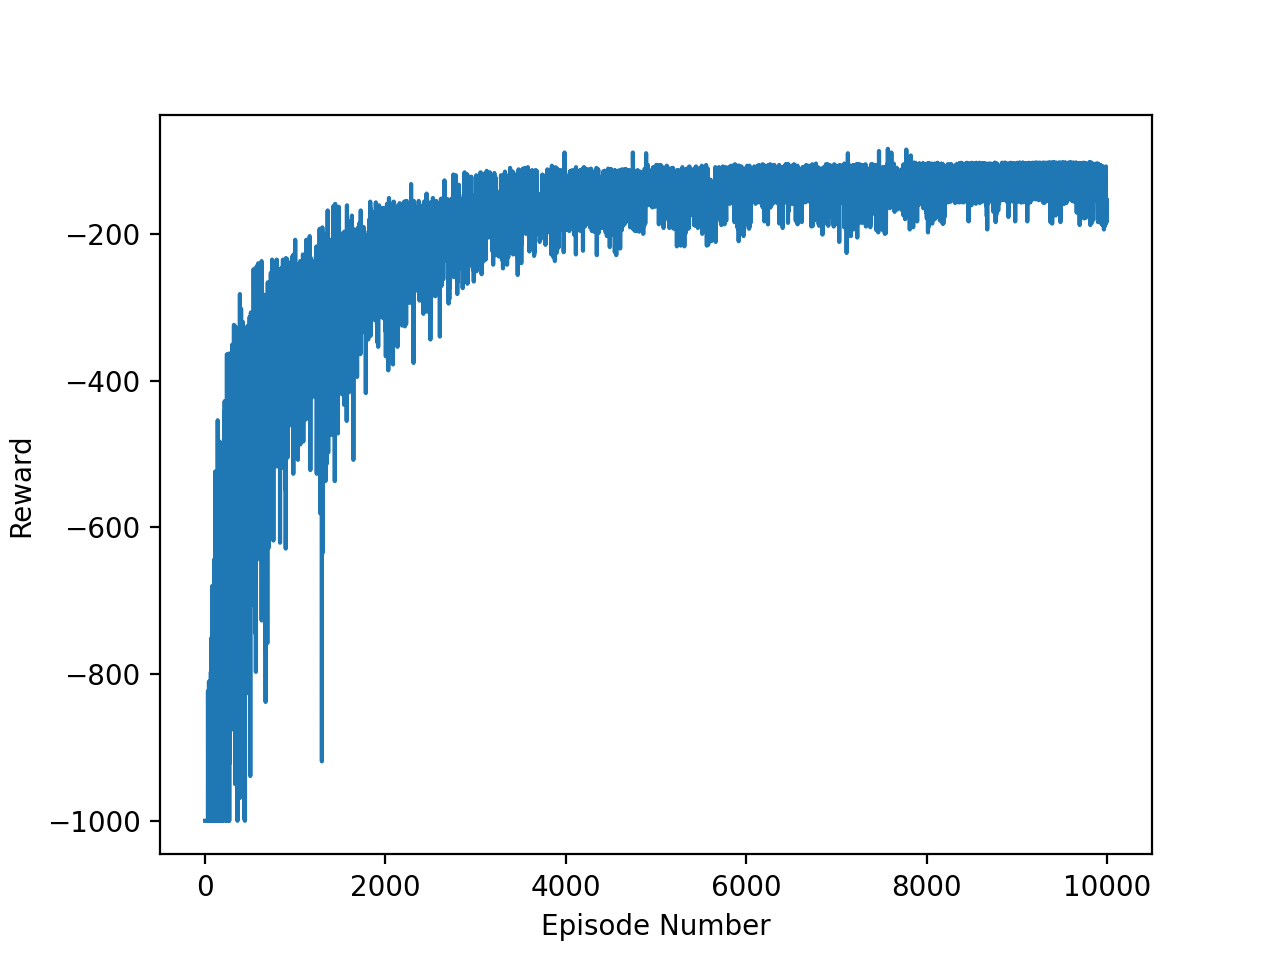

In [8]:
## PLOT THE TOTAL REWARD PER EPISODE AS TRAINING PROGRESSES
## You will need the array Rs

plt.figure()
plt.plot(np.sum(Rs,1))
plt.xlabel('Episode Number')
plt.ylabel('Reward')
plt.show()


<IPython.core.display.Javascript object>


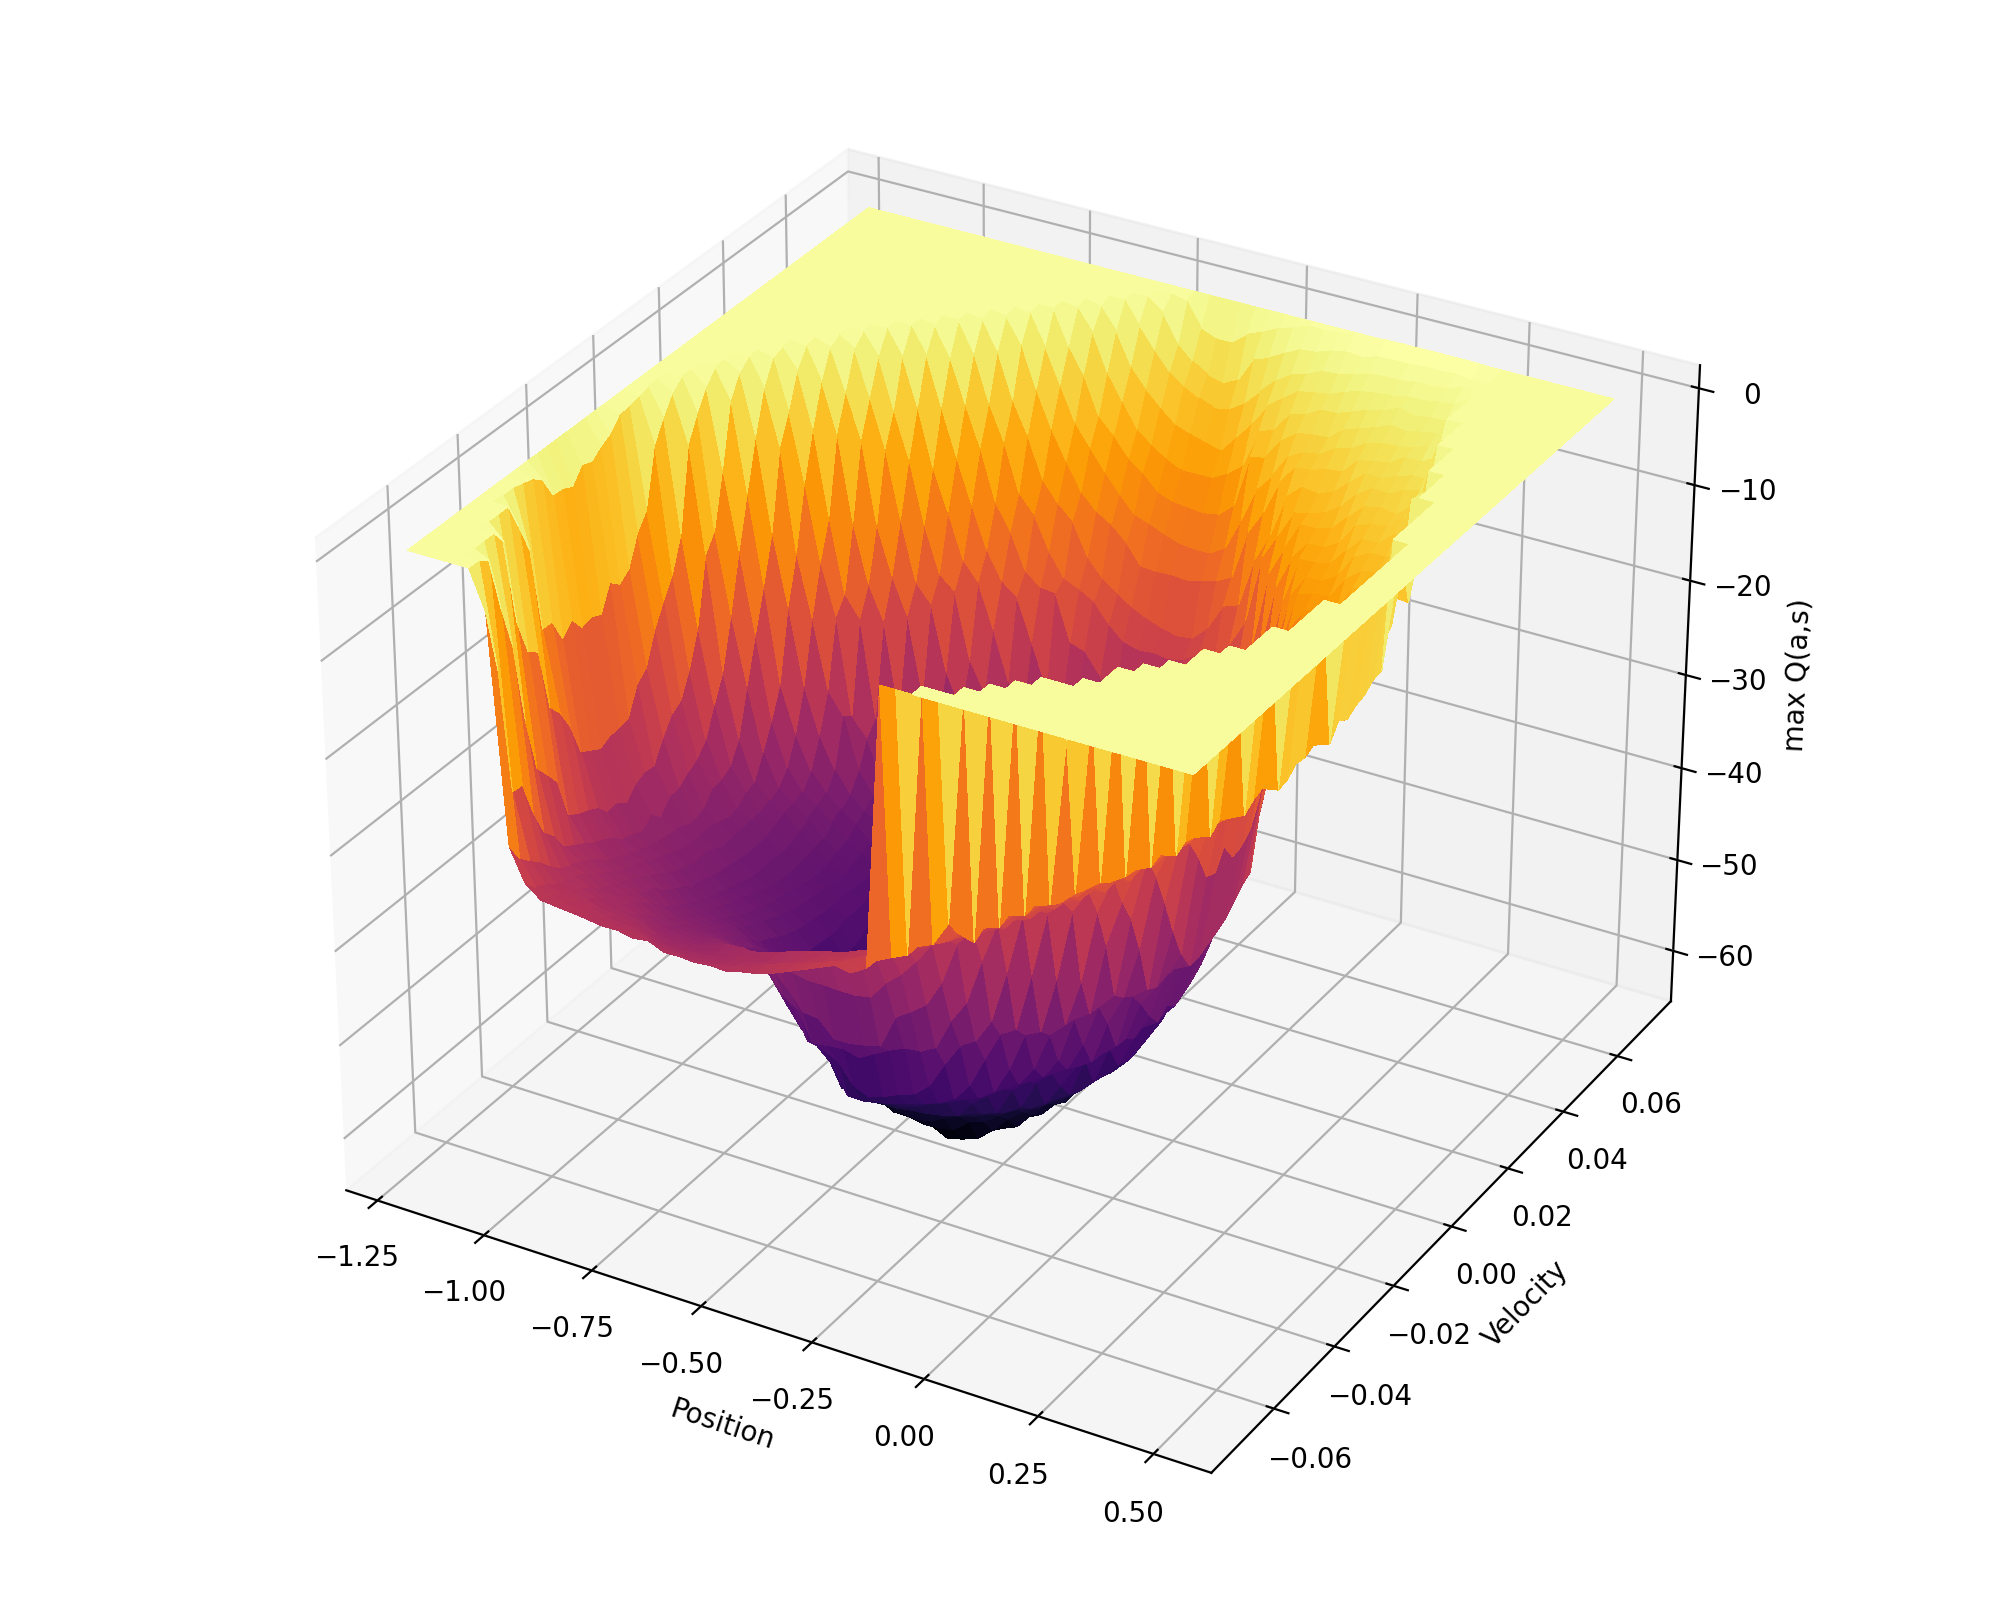

In [10]:
## PLOT THE BEST Q-VALUES AFTER TRAINING
## You will need the final value for the Qvalues, saved in a table called Qtable of shape [3,N_x,N_v], where N_x and N_v
## are the grids sizes for the positions and velocities respectively

from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=(10,8))

# Prepare the data
X_plot, Y_plot = np.meshgrid(X, V)

surf = ax.plot_surface(X_plot, Y_plot, np.max(Qtable,0),cmap=cm.inferno,
                       linewidth=0, antialiased=False)

ax.set_xlabel('Position')
ax.set_ylabel('Velocity')
ax.set_zlabel('max Q(a,s)')

plt.tight_layout()
plt.show()

